In [98]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd

from functools import lru_cache
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature

import emcee

In [50]:
def setMplParam(classNum):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 5  # Example size
    plt.rcParams['lines.linewidth'] = 2  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

setMplParam(6)

In [53]:
bound1 = (0, 1)

In [56]:
@lru_cache(maxsize = None)
def integrateMC(f, bound, *par):
    N = 10000
    x = np.random.uniform(bound[0], bound[1], N)
    fx = f(x, *par)
    y = np.random.uniform(0, np.max(fx), N)
    ratio = np.sum(y < fx) / N
    norm = ratio * (bound[1] - bound[0]) * np.max(fx)
    return norm

In [39]:
def generateBetaPrior(a, b, n = 1000):
    x = np.linspace(bound1[0], bound1[1], n)
    y = stats.beta.pdf(x, a, b)
    return x, y

In [132]:
def unnormalisedBeta(x, a, b):
    return x**(a-1) * (1-x)**(b-1)

def normalisedBeta(x, a, b):
    return unnormalisedBeta(x, a, b) / integrateMC(unnormalisedBeta, bound1, a, b)

In [149]:
def normaliseData(data):
    return (data - np.mean(data)) / np.std(data)

In [162]:
def binomialLLH(n, N, p):
    return stats.binom.pmf(n, N, p)

(array([0.00000000e+00, 1.01570110e-07, 1.59926260e-06, 7.96730968e-06,
        2.47791567e-05, 5.95304865e-05, 1.21470339e-04, 2.21440054e-04,
        3.71719791e-04, 5.85882351e-04, 8.78654080e-04, 1.26578259e-03,
        1.76391109e-03, 2.39045907e-03, 3.16350915e-03, 4.10169984e-03,
        5.22412404e-03, 6.55023309e-03, 8.09974605e-03, 9.89256424e-03,
        1.19486906e-02, 1.42881539e-02, 1.69309375e-02, 1.98969125e-02,
        2.32057753e-02, 2.68769887e-02, 3.09297280e-02, 3.53828295e-02,
        4.02547439e-02, 4.55634923e-02, 5.13266259e-02, 5.75611890e-02,
        6.42836848e-02, 7.15100442e-02, 7.92555978e-02, 8.75350500e-02,
        9.63624562e-02, 1.05751202e-01, 1.15713986e-01, 1.26262801e-01,
        1.37408926e-01, 1.49162906e-01, 1.61534552e-01, 1.74532923e-01,
        1.88166330e-01, 2.02442324e-01, 2.17367696e-01, 2.32948474e-01,
        2.49189928e-01, 2.66096565e-01, 2.83672137e-01, 3.01919641e-01,
        3.20841326e-01, 3.40438701e-01, 3.60712539e-01, 3.816628

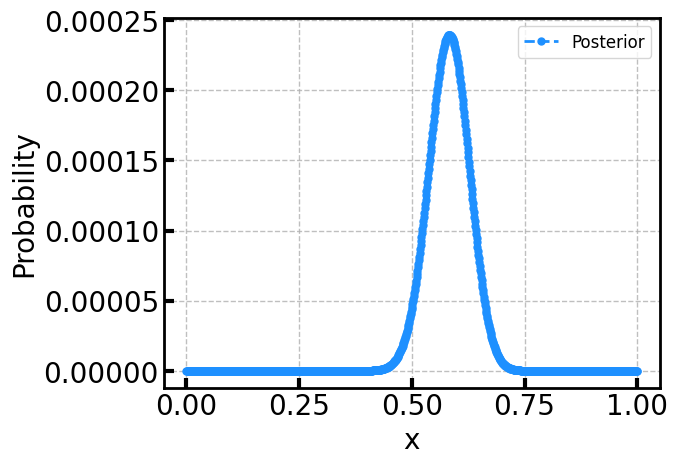

In [166]:
def CoinFlip():
    x = np.linspace(bound1[0], bound1[1], 1000)
    
    prior = normalisedBeta(x, 5, 17)
    likelihood = binomialLLH(66, 100, x)
    posterior = prior * likelihood

    # prior = normaliseData(prior)
    # likelihood = normaliseData(likelihood)
    # posterior = normaliseData(posterior)

    fig, ax = plt.subplots()
    # ax.plot(x, prior, label = 'Prior')
    # ax.plot(x, likelihood, label = 'Likelihood')
    ax.plot(x, posterior, label = 'Posterior')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability')
    ax.legend()
    return prior, likelihood, posterior


CoinFlip()

# Step 

In [96]:
def stepPdf(x, previous):
    mu = previous / 2
    return stats.norm.pdf(x, mu, 1)

def rejection_sampling(pdf, previous, samples=1):
    x_min, x_max = bound1
    y_max = pdf(np.mean(domain), previous)  # Approximation; adjust based on actual max of your PDF
    accepted = []
    while len(accepted) < samples:
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(0, y_max)
        if y < pdf(x, previous):
            accepted.append(x)
    return accepted[0] if samples == 1 else accepted


In [130]:
def generateRandomNumber(previous):
    mu = previous / 2
    sigma = 1  # Standard deviation
    return np.random.normal(mu, sigma)

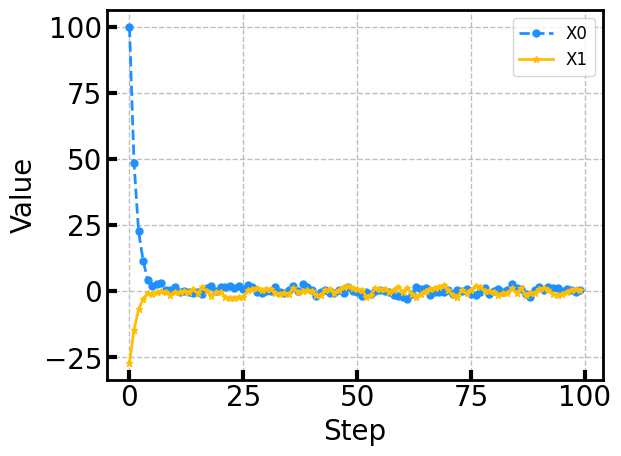

In [131]:
def stepMCMC():
    X0_0 = 100
    X1_0 = -27
    X0 = np.zeros(100)
    X1 = np.zeros(100)
    X0[0] = X0_0
    X1[0] = X1_0
    for i in range(1, 100):
        X0[i] = generateRandomNumber(X0[i-1])
        X1[i] = generateRandomNumber(X1[i-1])
    fig, ax = plt.subplots()
    ax.plot(X0, label = 'X0')
    ax.plot(X1, label = 'X1')
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.legend()

stepMCMC()

In [94]:
to generate a random number from a pdf

SyntaxError: invalid syntax (2294589919.py, line 1)

In [147]:
def Beta(x, a, b):
    return x**(a-1) * (1-x)**(b-1)
def randomBeta(a, b):
    x = np.linspace(0, 1, 1000)  # Discretize the interval [0, 1]
    y = Beta(x, a, b)
    y /= y.sum()  # Normalize the probabilities so they sum to 1
    return np.random.choice(x, p=y)

# Example usage
print(randomBeta(5, 17))

0.12312312312312312


In [157]:
def binomialLLH(x):
    Nflip = 100
    # Nhead = 66
    return stats.binom.pmf(x, Nflip, 0.5)

In [158]:
def transitionProbability(new_prior, new_likelihood, previous_prior, previous_likelihood):
    new = new_prior * new_likelihood
    previous = previous_prior * previous_likelihood
    r = new/ previous
    if r > 1:
        p = 1
    else:
        p = r
    return p

In [167]:
def conventionalWay():
    prior = randomBeta(5, 17)
    likelihood = binomialLLH(prior)
    posterior = prior * likelihood
    
conventionalWay()

TypeError: binomialLLH() missing 2 required positional arguments: 'N' and 'p'

In [ ]:
def metropolisHastings():